# PyTorch dataset template

by Andrés Muñoz-Jaramillo

This notebook is meant to act as a template to create a custom dataset based on a downstream application (DS) index.

It requires an DS index file to be combined with a HelioFM index.  It also shows how to create a child database class based on HelioFM's database class so that all the code related to the input data is handled transparently, while the new code focuses exclusively in adding the DS information

This template uses a flare forecasting dataset as an example, casting the problem as an X-ray flux regression problem

In [1]:
import numpy as np
import sys
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import sunpy.visualization.colormaps as cm
import matplotlib.gridspec as gridspec

import yaml



# Append base path.  May need to be modified if the folder structure changes.
# It gives the notebook access to the wokshop_infrastructure folder.
sys.path.append("../../")
 
# Append Surya path. May need to be modified if the folder structure changes.
# It gives the notebook access to surya's release code.
sys.path.append("../../Surya")

from surya.utils.data import build_scalers  # Data scaling utilities for Surya stacks

## Download scalers
Surya input data needs to be scaled properly for the model to work and this cell downloads the scaling information.

- If the cell below fails, try running the provided shell script directly in the terminal.
- Sometimes the download may fail due to network or server issues—if that happens, simply re-run the script a few times until it completes successfully.

In [2]:
!sh download_scalers.sh

==> Checking assets directory at: /home/nishukarna/workspace/surya_workshop/downstream_apps/template/assets
==> Downloading scalers.yaml from nasa-ibm-ai4science/core-sdo


Fetching 1 files: 100%|█████████████████████████| 1/1 [00:00<00:00, 2027.21it/s]
Download complete: : 0.00B [00:00, ?B/s]              /home/nishukarna/workspace/surya_workshop/downstream_apps/template/assets
Download complete: : 0.00B [00:00, ?B/s]
✓ Done. File is located at: /home/nishukarna/workspace/surya_workshop/downstream_apps/template/assets/scalers.yaml


## Load configuration

Surya was designed to read a configuration file that defines many aspects of the model
including the data it uses we use this config file to set default values that do not
need to be modified, but also to define values specific to our downstream application

In [3]:
# Configuration paths - modify these if your files are in different locations
config_path = "./configs/config.yaml"

# Load configuration
print("📋 Loading configuration...")
try:
    config = yaml.safe_load(open(config_path, "r"))
    config["data"]["scalers"] = yaml.safe_load(open(config["data"]["scalers_path"], "r"))
    print("✅ Configuration loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Make sure config.yaml exists in your current directory")
    raise

scalers = build_scalers(info=config["data"]["scalers"])

📋 Loading configuration...
✅ Configuration loaded successfully!


## Define DS dataset

This child class takes as input all expected HelioFM parameters, plus additonal parameters relevant to the downstream application.  Here we focus in particular to the DS index and parameters necessary to combine it with the HelioFM index.

Another important component of creating a dataset class for your DS is normalization.  Here we use a log normalization on xray flux that will act as the output target.  Making log10(xray_flux) strictly positive and having 66% of its values between 0 and 1

Since we are going to use this dataset moving forward, it is better to develop it as script and not as a notebook.

In [4]:
from downstream_apps.template.datasets.template_dataset_fm import FlareDSDataset

## Initialize class without Surya stacks

All the parameters that define a HelioFM dataset are contained within the test config file.  Scalers used to normalize HelioFm's input data are also necessary

**_Important: This first initalization is set not to return the full Surya stack so that we can verify that the target is returning what we expect. This is so that you can check things quickly without having to pull full stacks until you need them._**

_We do this by setting return_surya_stack=False_

Make sure to set return_surya_stack=True if you need the full surya stack at this stage, otherwise we'll reinitialize the dataset shortly.

**_Important:  In this notebook we sets max_number_of_samples=6 to potentially avoid going through the whole dataset as we explore it.  Keep in mind this for the future in case the database seems smaller than you expect_**


In [5]:
train_dataset = FlareDSDataset(
    #### All these lines are required by the parent HelioNetCDFDataset class
    index_path=config["data"]["train_data_path"],
    time_delta_input_minutes=config["data"]["time_delta_input_minutes"],
    time_delta_target_minutes=config["data"]["time_delta_target_minutes"],
    n_input_timestamps=config["model"]["time_embedding"]["time_dim"],
    rollout_steps=config["rollout_steps"],
    channels=config["data"]["channels"],
    drop_hmi_probability=config["drop_hmi_probability"],
    use_latitude_in_learned_flow=config["use_latitude_in_learned_flow"],
    scalers=scalers,
    phase="train",
    s3_use_simplecache = True,
    s3_cache_dir= "/tmp/helio_s3_cache",    
    #### Put your donwnstream (DS) specific parameters below this line
    return_surya_stack=False,
    max_number_of_samples=6,
    ds_flare_index_path="./data/test_surya_20110825.csv",
    ds_time_column="timestep",
    ds_time_tolerance = "4d",
    ds_match_direction = "forward"    
)

Hello


## Test length and structure

Now we can test that the database is properly initialized and returns what is expected. In th case of the template, there are 6294 flares that take place during the training split

In [6]:
train_dataset.__len__()

6

In [7]:
item = train_dataset.__getitem__(0)
item.keys()

2011-08-25 00:00:01
(4096, 4096)
{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096), dtype=float32), 'ds_index': '2011-08-25 00:00:01'}


dict_keys(['mask', 'ds_index'])

Note that the dataset returns a single item and it's always the same item according to the index used:

In [8]:
train_dataset.__getitem__(0)

2011-08-25 00:00:01
(4096, 4096)
{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096), dtype=float32), 'ds_index': '2011-08-25 00:00:01'}


{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096), dtype=float32),
 'ds_index': '2011-08-25 00:00:01'}

In [9]:
train_dataset.__getitem__(3)

2011-08-25 00:36:01
(4096, 4096)
{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096), dtype=float32), 'ds_index': '2011-08-25 00:36:01'}


{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096), dtype=float32),
 'ds_index': '2011-08-25 00:36:01'}

In [10]:
train_dataset.__getitem__(3)

2011-08-25 00:36:01
(4096, 4096)
{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096), dtype=float32), 'ds_index': '2011-08-25 00:36:01'}


{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096), dtype=float32),
 'ds_index': '2011-08-25 00:36:01'}

## Define dataloader

With a working dataset we can define a dataloader.  A dataloader is simply a wrapper around a dataset that includes a sampling strategy to turn your dataset into batches.   Once we request a batch, the dataloader will return a dictionary like the dataset, but data inside will have a batch dimension

In [11]:
data_loader = DataLoader(
                dataset=train_dataset,
                batch_size=5,
                num_workers=8
            )

In [12]:
batch = next(iter(data_loader))
batch.keys()

2011-08-25 01:00:012011-08-25 00:00:01

(4096, 4096)(4096, 4096)

{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096), dtype=float32), 'ds_index': '2011-08-25 00:00:01'}{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096), dtype=float32), 'ds_index': '2011-08-25 01:00:01'}

2011-08-25 00:12:01
(4096, 4096)
{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(40

dict_keys(['mask', 'ds_index'])

Now the batch will have more than one item

In [13]:
batch

{'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],

Typically we set dataloaders to shufle the data so that the model sees data in different order during training.  This means that in general we don't want and don't expect the batch to return the same sequence of events.

In [14]:
data_loader = DataLoader(
                dataset=train_dataset,
                batch_size=5,
                shuffle=True,
            )

next(iter(data_loader))

2011-08-25 00:12:01
(4096, 4096)
{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096), dtype=float32), 'ds_index': '2011-08-25 00:12:01'}
2011-08-25 00:24:01
(4096, 4096)
{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096), dtype=float32), 'ds_index': '2011-08-25 00:24:01'}
2011-08-25 00:36:01
(4096, 4096)
{'mask': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(40

{'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],

## Initialize class with Surya stacks

Now we initalize the database to return full surya stacks to visualize them by setting _return_surya_stack=True_

In [15]:
train_dataset = FlareDSDataset(
    #### All these lines are required by the parent HelioNetCDFDataset class
    index_path=config["data"]["train_data_path"],
    time_delta_input_minutes=config["data"]["time_delta_input_minutes"],
    time_delta_target_minutes=config["data"]["time_delta_target_minutes"],
    n_input_timestamps=config["model"]["time_embedding"]["time_dim"],
    rollout_steps=config["rollout_steps"],
    channels=config["data"]["channels"],
    drop_hmi_probability=config["drop_hmi_probability"],
    use_latitude_in_learned_flow=config["use_latitude_in_learned_flow"],
    scalers=scalers,
    phase="train",
    s3_use_simplecache = True,
    s3_cache_dir= "/tmp/helio_s3_cache",    
    #### Put your donwnstream (DS) specific parameters below this line
    return_surya_stack=True,
    max_number_of_samples=6,
    ds_flare_index_path="./data/test_surya_20110825.csv",
    ds_time_column="timestep",
    ds_time_tolerance = "4d",
    ds_match_direction = "forward"    
)

Hello


In surya's convention an item contains the following elements:
- 'ts': input tensor.
- 'time_delta_input': minutes with respect to the present in the time dimension of the input tensor.
- 'forecast': target SDO stack.
- 'lead_time_delta': how many minutes into the future is the target stack with respect to the present.


In [16]:
item = train_dataset.__getitem__(0)
item.keys()

2011-08-25 00:00:01
(4096, 4096)
{'ts': array([[[[-2.1257731e-01, -2.1257751e-01, -5.3461140e-01, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01],
         [-2.1257751e-01, -2.1258543e-01, -5.3461140e-01, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01],
         [-5.4036492e-01, -5.4036492e-01, -5.3461140e-01, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01],
         ...,
         [-1.9231305e-01, -2.6508591e-01, -3.3476308e-01, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01],
         [-1.8662411e-01, -1.8662435e-01,  9.6938469e-02, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01],
         [-5.4036492e-01, -5.4036492e-01,  9.6938603e-02, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01]]],


       [[[-6.3146430e-01, -5.5773759e-01, -6.5620124e-01, ...,
          -6.7832291e-01, -6.2537122e-01, -6.3304514e-01],
         [-6.2928873e-01, -6.2210250e-01, -5.6877536e-01, ...,
          -6.7832291e-01,

dict_keys(['ts', 'time_delta_input', 'forecast', 'lead_time_delta', 'mask', 'ds_index'])

The shape of the input tensors has dimensions [C, T, H, W], where
- C: instrument channels.
- T: timestamps.
- H: Height.
- W: Width.

In [17]:
item['ts'].shape

(13, 1, 4096, 4096)

## Plotting input stack

Before plotting, it is necessary to undo the z-score and logarithmic normalization.

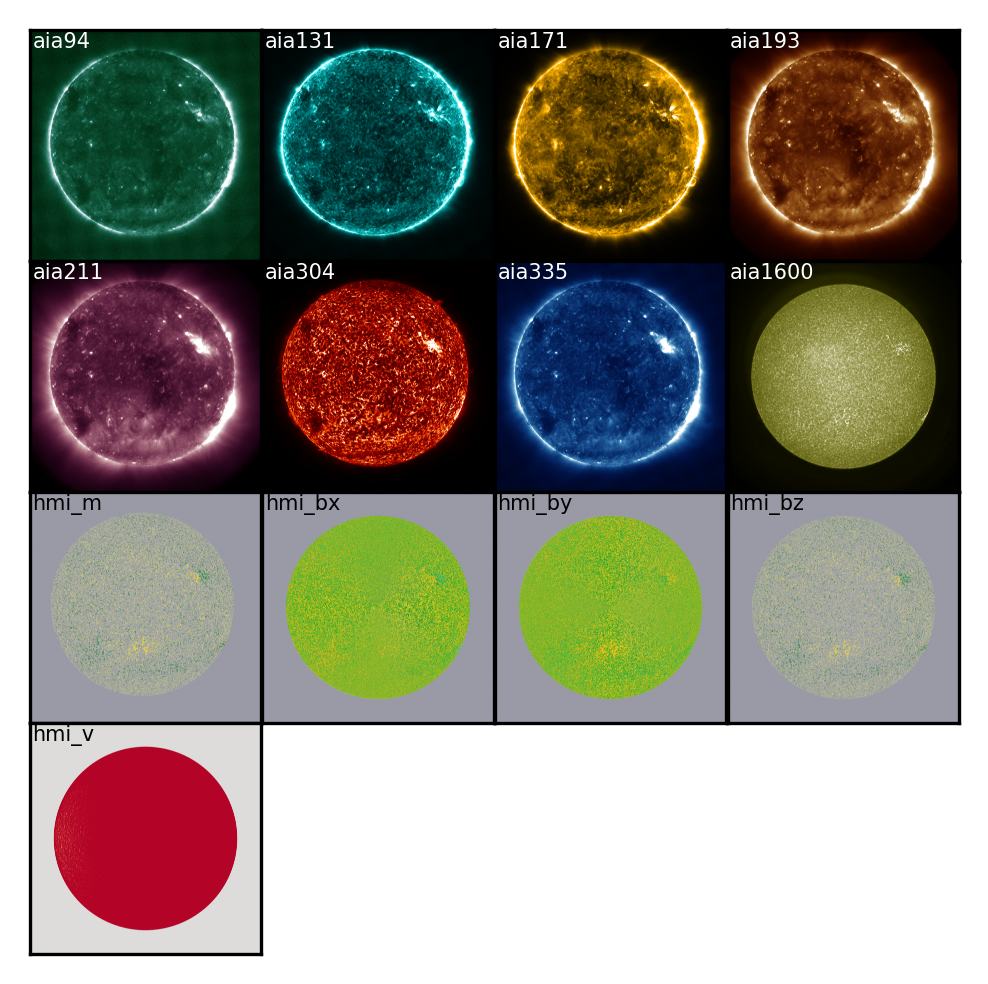

In [18]:
unnormalized_ts = train_dataset.inverse_transform_data(item['ts'][:,0,...])
channel_order = config["data"]["channels"]
fig = plt.figure(figsize=np.array([4,4]), dpi=300)
gs = gridspec.GridSpec(4, 4, figure=fig, wspace=0, hspace=0)

limits = {}

for i in range(4):
    for j in range(4):
        n = i*4 + j
        if n < len(channel_order):

            ax = fig.add_subplot(gs[i,j])
            channel = channel_order[n]
            if 'hmi' not in channel:
                lim = np.percentile(unnormalized_ts[n,...][unnormalized_ts[n,...]!=0], 99)
                ax.imshow(unnormalized_ts[n,...], cmap=f'sdo{channel}', vmin=0, vmax=lim)
                font_color = 'w'

            else:
                font_color = 'k'
                if "_v" not in channel:
                    lim = 1000
                    ax.imshow(unnormalized_ts[n,...], cmap=f'hmimag', vmin = -lim, vmax=lim)
                else:
                    lim = 1000
                    ax.imshow(unnormalized_ts[n,...], cmap=f'coolwarm', vmin = -lim, vmax=lim)                    

            ax.text(0.01, 0.99, channel, transform=ax.transAxes, horizontalalignment='left', verticalalignment='top', color=font_color, fontsize=5)  
            ax.set_xticks([])
            ax.set_yticks([])             

## Define dataloader

Now the dataloader will return also a surya stack alongside our flaring data

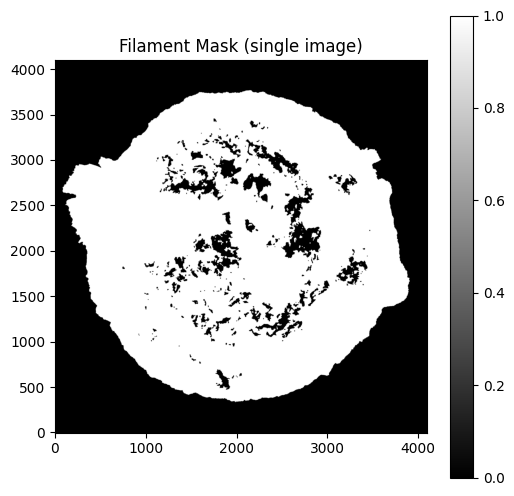

In [19]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

mask_fits_path = "/shared/huggingface_data/filaments/AIA171_masked_20110825_010000.fits"

with fits.open(mask_fits_path) as hdul:
    mask = hdul[0].data

mask = (mask > 0).astype(np.float32)

plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap="gray",origin="lower")
plt.title("Filament Mask (single image)")
plt.colorbar()
plt.show()

In [20]:
data_loader = DataLoader(
                dataset=train_dataset,
                batch_size=2
            )

In [21]:
batch = next(iter(data_loader))
batch.keys()

2011-08-25 00:00:01
(4096, 4096)
{'ts': array([[[[-2.1257731e-01, -2.1257751e-01, -5.3461140e-01, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01],
         [-2.1257751e-01, -2.1258543e-01, -5.3461140e-01, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01],
         [-5.4036492e-01, -5.4036492e-01, -5.3461140e-01, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01],
         ...,
         [-1.9231305e-01, -2.6508591e-01, -3.3476308e-01, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01],
         [-1.8662411e-01, -1.8662435e-01,  9.6938469e-02, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01],
         [-5.4036492e-01, -5.4036492e-01,  9.6938603e-02, ...,
          -5.4036492e-01, -5.4036492e-01, -5.4036492e-01]]],


       [[[-6.3146430e-01, -5.5773759e-01, -6.5620124e-01, ...,
          -6.7832291e-01, -6.2537122e-01, -6.3304514e-01],
         [-6.2928873e-01, -6.2210250e-01, -5.6877536e-01, ...,
          -6.7832291e-01,

dict_keys(['ts', 'time_delta_input', 'forecast', 'lead_time_delta', 'mask', 'ds_index'])

And now it will also have a batch dimension of 2 (batch dimensions are typically the leftmost dimension in a tensor's shape)

In [22]:
batch['ts'].shape

torch.Size([2, 13, 1, 4096, 4096])

## Conclusions

Once this notebook runs successfully you have a dataset and dataloaders done and ready to train a DS application. The next step continues in 1_baseline_template.ipynb which will involve putting together a simple baseline including metrics and a training loop that can be used to compare with Surya.